In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def Gaussian_pdf(x,name,para):
    mu=para[name+'_mean']
    sigma=para[name+'_sd']
    return math.exp(((x-mu)/sigma)**2*(-1/2))/(sigma*math.sqrt(2*math.pi))

def normialise(tem_dist):
    return [tem_dist[i]/sum(tem_dist) for i in range(len(tem_dist))]
def second_moment(name,para):
    return para[name+'_mean']**2+para[name+'_sd']**2

def data_generation(num,para):
    name_list=['af','bf','am','bm']
    df=pd.DataFrame(columns=['X', 'U', 'S'])
    for name in name_list:
        size=int(para[name]*num)
        X=np.floor((np.random.normal(para['X_'+name+'_mean'],para['X_'+name+'_sd'],size=[size])-horizen[0])/width)
        #np.random.normal(para['X_'+name+'_mean'],para['X_'+name+'_sd'],size=[size])
        U=[name[0]]*size
        S=[name[1]]*size
        df=pd.concat([df, pd.DataFrame([X,U,S], index=['X','U','S']).T], ignore_index=True)
    df['W']=1
    df['X']=df['X'].astype('int64')  
    return df
def empirical_distribution(sub,dist):
    bin=dist['bin']
    dist=np.zeros(bin)
    for i in range(bin):
        subset=sub[sub['X']==i] #bin_value=x_range[i] #sub[(sub['X']>=bin_value)&(sub['X']<bin_value+width)]
        if subset.shape[0]>0:
            dist[i]=sum(subset['W'])
    if sum(dist)>0:
        return dist/sum(dist)
    else:
        return dist

def samples_groupby(data):
    # for better complexity
    df=data.groupby(by=['X','U','S'],as_index=False).sum()
    return df[df['W']!=0]
def projection(df,coupling):
    df_t=pd.DataFrame(columns=['X', 'U', 'S','W'])
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        sub=pd.DataFrame(columns=['X','W'],index=[*range(bin)])
        sub['X']=[*range(bin)]
        sub['W']=coupling[:,orig[0]]/(sum(coupling[:,orig[0]])+0.0001)*orig[3]
        sub['U']=orig[1]
        sub['S']=orig[2]
        df_t=pd.concat([df_t, samples_groupby(sub)], ignore_index=True)
    return df_t

In [2]:
import mosek

In [3]:
def msk_relent(task, t, x, y):
    v = msk_newvar(task, 1)
    c = msk_newcon(task, 1)
    task.putaij(c, v, 1.0)
    task.putaij(c, t, 1.0)

    task.putconbound(c, mosek.boundkey.fx, 0.0, 0.0)
    task.appendcone(mosek.conetype.pexp, 0.0, [y, x, v])

def msk_newvar(task, num):  # free
    v = task.getnumvar()
    task.appendvars(num)
    for i in range(num):
        task.putvarbound(v+i, mosek.boundkey.fr, -inf, inf)
    return v

def msk_newvar_fx(task, num, val):  # fixed
    v = task.getnumvar()
    task.appendvars(num)
    for i in range(num):
        task.putvarbound(v+i, mosek.boundkey.fx, val, val)
    return v

def msk_newcon(task, num):
    c = task.getnumcon()
    task.appendcons(num)
    return c

def msk_sq(task, t, x): # t >= x^2
    task.appendcone(mosek.conetype.rquad, 0.0, [msk_newvar_fx(task, 1, 0.5), t, x])

In [4]:
keys = ['t','a_f', 'a_m','b_f', 'b_m']
values = [0.2,0.2,0.8,0.8,0.2]
para = dict(zip(keys, values))
para['X_af_mean']=-10
para['X_af_sd']=5
para['X_bf_mean']=-20
para['X_bf_sd']=5
para['X_am_mean']=20
para['X_am_sd']=1
para['X_bm_mean']=10
para['X_bm_sd']=1
para['f']=1/2-para['t']
para['m']=1/2+para['t']
para['a']=para['a_f']*para['f']+para['a_m']*para['m']
para['b']=para['b_f']*para['f']+para['b_m']*para['m']
para['af']=para['a_f']*para['f']
para['bf']=para['b_f']*para['f']
para['am']=para['a_m']*para['m']
para['bm']=para['b_m']*para['m']
para['f_a']=para['af']/para['a'] #inverse_probability('f_a',para)
para['m_a']=para['am']/para['a'] #inverse_probability('m_a',para)
para['f_b']=para['bf']/para['b'] #inverse_probability('f_b',para)
para['m_b']=para['bm']/para['b'] #inverse_probability('m_b',para)

In [6]:
horizen=[-50,50]
width=1
bin=int((horizen[1]-horizen[0])/width)
x_range=np.arange(horizen[0],horizen[1],width)
dist = dict(zip(['horizen','width','bin','x_range'],[horizen,width,bin,x_range]))
dist['x_af']=[Gaussian_pdf(x,'X_af',para)*width for x in x_range]
dist['x_am']=[Gaussian_pdf(x,'X_am',para)*width for x in x_range]
dist['x_bf']=[Gaussian_pdf(x,'X_bf',para)*width for x in x_range]
dist['x_bm']=[Gaussian_pdf(x,'X_bm',para)*width for x in x_range]
dist['x_a']=[dist['x_af'][i]*para['a_f']+dist['x_am'][i]*para['a_m'] for i in range(bin)]
dist['x_b']=[dist['x_bf'][i]*para['b_f']+dist['x_bm'][i]*para['b_m'] for i in range(bin)]

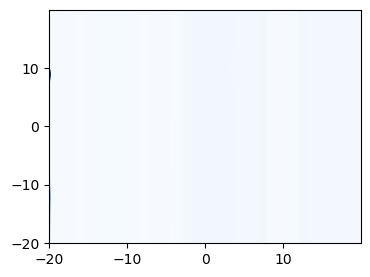

In [33]:
fig = plt.figure(figsize=(4, 3))
gs = fig.add_gridspec(2, 2, width_ratios=(bin, 1), height_ratios=(1, bin),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax.pcolormesh(x_range, x_range, output['b'], cmap='Blues')

In [7]:
inf=100
def LP(T,px_u,px_uf,px_um):
    env  = mosek.Env()
    task = env.Task(0,0)

    # variables -------------------------------------------------------------
    p = msk_newvar(task, T*T) # (i,j)=i+j*T
    #n = msk_newvar(task, T) # absolute value of CI difference
    tx = msk_newvar(task, T) # 
    eta = msk_newvar(task, T) # relative entropy of tx

    # constraints ------------------------------------------------------------
    # 0<p<1
    for i in range(T*T):
        task.putvarbound(p+i, mosek.boundkey.ra, -0.0001, 1)

    # sum p=1
    c = msk_newcon(task, 1)
    task.putarow(c, range(p,p+T*T),[1.0]*(T*T))
    task.putconbound(c, mosek.boundkey.fx,1,1)  

    # \sum_{j}p[i,j]=p[x=i|u]
    for i in range(T):
        c = msk_newcon(task, 1)
        task.putarow(c, range(p+i,p+i+T),[1.0]*T)
        task.putconbound(c, mosek.boundkey.fx,px_u[i],px_u[i])  

    # \sum_{i}p[i,j]=p[tx=j|u]
    for j in range(T):
        c = msk_newcon(task, 1)
        task.putarow(c,[tx+j]+[p+i+j*T for i in range(T)],[-1.0]+[1.0]*T)
        task.putconbound(c, mosek.boundkey.fx,0,0)  
    
    # max relative entropy
    for i in range(T):
        msk_relent(task, eta+i, tx+i, msk_newvar_fx(task, 1, px_u[i])) #(t,x,y) t >= x * log(x/y), x,y>=0  --> -t <= -x * log x 

    # \sum_{i}p[i,j]p[i|u,s=0]/p[i|u,s=0]=\sum_{i}p[i,j]p[i|u,s=1]/p[i|u,s=0], for all j
    # \sum_{i}p[i,j]/p[i|u,s=0](p[i|u,s=0]-p[i|u,s=0])=0, for all j
    for j in range(T):
        c = msk_newcon(task, 1)
        task.putarow(c,[p+i+j*T for i in range(T)],[(px_uf[i]-px_um[i]) for i in range(T)])
        task.putconbound(c, mosek.boundkey.fx,0,0)

    #  for j in range(T):
    #     c = msk_newcon(task, 2)
    #     task.putarow(c,[n+j]+[p+i+j*T for i in range(T)],[1.0]+[(px_uf[i]-px_um[i]) for i in range(T)])
    #     task.putconbound(c, mosek.boundkey.lo,0,inf)
    #     task.putarow(c+1,[n+j]+[p+i+j*T for i in range(T)],[1.0]+[-(px_uf[i]-px_um[i]) for i in range(T)])
    #     task.putconbound(c+1, mosek.boundkey.lo,0,inf)
    
    # objective ----------------------------------------------------------------
    task.putclist([*range(eta,eta+T)],[0.01]*T) #[*range(n,n+T)]+

    # Input the objective sense (minimize/maximize)
    task.putobjsense(mosek.objsense.minimize)

    # get solution
    task.optimize()
    xx = [0.0]*task.getnumvar()
    task.getxx(mosek.soltype.itr,xx)
    print(task.getsolsta(mosek.soltype.itr))
    return xx,p

In [ ]:
U_range=['a','b'] #,'b'
output=dict(key=U_range)
for u in U_range:
    output_tem=np.zeros((bin,bin))
    px_u=dist['x_'+u]
    px_uf=dist['x_'+u+'f']
    px_um=dist['x_'+u+'m']
    xx,p=LP(bin,px_u,px_uf,px_um)
    for i in range(bin):
        for j in range(bin):
            if xx[p+i+bin*j]>0:
                output_tem[i,j]=xx[p+i+bin*j] 
    output[u]=output_tem/sum(sum(output_tem))

In [15]:
data

,X,U,S,W
0,-191,b,f,1
1,-173,b,f,1
2,-155,b,f,1
3,-153,b,f,1
4,-152,b,f,1
...,...,...,...,...
584,429,a,m,2
585,431,a,m,2
586,432,a,m,2
587,435,a,m,1


In [10]:
data_revised=pd.concat([projection(data[data['U']==u],output[u]) for u in U_range],ignore_index=True)

IndexError: index 400 is out of bounds for axis 1 with size 400

In [9]:
num=10000
data=samples_groupby(data_generation(num,para))
data_revised=pd.concat([projection(data[data['U']==u],output[u]) for u in U_range],ignore_index=True)
name_list=['af','bf','am','bm']
dist_source=dict()
dist_project=dict() #dict(keys=['x_'+i for i in name_list])
for name in name_list:
    dist_source['x_'+name] =empirical_distribution(data[(data['U']==name[0])&(data['S']==name[1])],dist)
    dist_project['x_'+name]=empirical_distribution(data_revised[(data_revised['U']==name[0])&(data_revised['S']==name[1])],dist)

IndexError: index 400 is out of bounds for axis 1 with size 400

Text(0.5, 1.0, 'source data distribution')

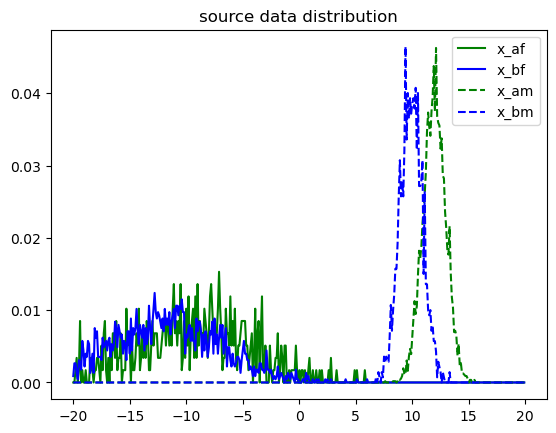

In [39]:
for key,value in dist_source.items():
    linestyle=str('g' if key[-2]=='a' else 'b')+str('-' if key[-1]=='f' else '--')
    plt.plot(x_range,value,linestyle,label=key)
plt.xlabel('Domain')
plt.ylabel('PDF')
plt.legend()
plt.title('source data distribution')

Text(0.5, 1.0, 'projected data distribution')

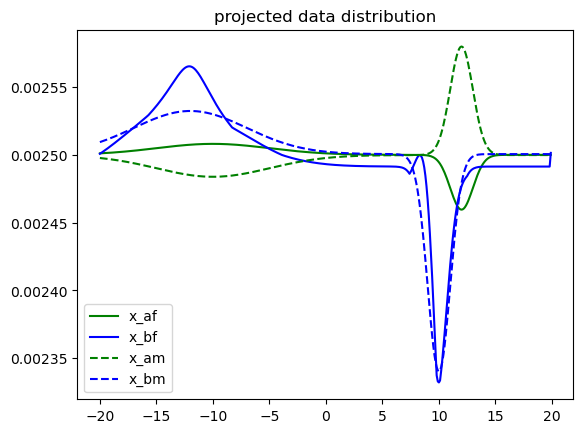

In [40]:
for key,value in dist_project.items():
    linestyle=str('g' if key[-2]=='a' else 'b')+str('-' if key[-1]=='f' else '--')
    plt.plot(x_range,value,linestyle,label=key)
plt.legend()
plt.title('projected data distribution')